## import libraries 

In [1]:
from collections import OrderedDict

In [ ]:

!wget http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/gdb9.tar.gz

--2022-02-14 16:55:33--  http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/gdb9.tar.gz
Resolving deepchem.io.s3-website-us-west-1.amazonaws.com (deepchem.io.s3-website-us-west-1.amazonaws.com)... 52.219.117.3
Connecting to deepchem.io.s3-website-us-west-1.amazonaws.com (deepchem.io.s3-website-us-west-1.amazonaws.com)|52.219.117.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44852087 (43M) [application/x-gzip]
Saving to: ‘gdb9.tar.gz’

gdb9.tar.gz         100%[===================>]  42.77M  96.0MB/s    in 0.4s    

2022-02-14 16:55:33 (96.0 MB/s) - ‘gdb9.tar.gz’ saved [44852087/44852087]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# !wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
# !chmod +x Miniconda3-latest-Linux-x86_64.sh
# !time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
# !time conda install -q -y -c conda-forge rdkit

In [ ]:
# # version 2018 is quite easy
# # download & extract
# url = 'https://anaconda.org/rdkit/rdkit/2018.09.1.0/download/linux-64/rdkit-2018.09.1.0-py36h71b666b_1.tar.bz2'
# !curl -L $url | tar xj lib
# # move to python packages directory
# !mv lib/python3.6/site-packages/rdkit /usr/local/lib/python3.6/dist-packages/
# x86 = '/usr/lib/x86_64-linux-gnu'
# !mv lib/*.so.* $x86/
# # rdkit need libboost_python3.so.1.65.1
# !ln -s $x86/libboost_python3-py36.so.1.65.1 $x86/libboost_python3.so.1.65.1

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
#sys.path.append('/usr/local/lib/python3.7/site-packages/')
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [ ]:
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.7 MB 97.2 MB/s 


In [3]:
from rdkit import Chem, DataStructs

In [4]:

import deepchem as dc

In [5]:
from ipywidgets import FloatProgress
from IPython.display import display

In [6]:
from rdkit.Chem import AllChem
from deepchem.feat.graph_features import *

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [8]:

import wandb

In [9]:
wandb.init(project="qm9", entity="qm9")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mrunmay (qm9). Use `wandb login --relogin` to force relogin


## Parameters 

In [10]:
# N = 10000# number of molecules in the dataset
N = 133885
D = 75     # hidden dimension of each atom
E = 6      # dimension of each edge
T = 3      # number of time steps the message phase will run for
P = 32     # dimensions of the output from the readout phase, the penultimate output before the target layer
V = 11     # dimensions of the molecular targets or tasks

In [11]:
# TRAIN_SIZE = 8000
TRAIN_SIZE = 100000
# VALID_SIZE = 1000
VALID_SIZE = 30000
# TEST_SIZE  = 1000
TEST_SIZE  = 23885
BATCH_SIZE = 16
NUM_EPOCHS = 20


In [12]:
DF = np.random.uniform(0.01, 1)
LR = np.random.uniform(1e-5, 5e-4)
LF = DF * LR
# from google.colab import drive
# drive.mount('/content/gdrive')

In [13]:
print('decay factor          : %.6f'%(DF))
print('initial learning rate : %.6f'%(LR))
print('final learning rate   : %.6f'%(LF))

decay factor          : 0.805448
initial learning rate : 0.000359
final learning rate   : 0.000289


In [14]:
wandb.config = {
    "learning_rate": LF,
    "epochs": 20,
    "batch_size": 16
}

In [15]:
import numpy as np
import pandas as pd
qm9 = pd.read_csv('data/qm9.csv')

In [16]:
qm9.head()

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_1,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,...,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772
1,gdb_2,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,...,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802
2,gdb_3,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,...,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171
3,gdb_4,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,...,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724
4,gdb_5,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,...,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028


In [17]:
len(qm9)

133885

In [18]:
# list = []
# for i in range(20001,30001):
#     list.append(i)
# qm9 = qm9.iloc[list]

In [19]:
# len(list)

In [20]:
chemical_accuracy_dict = {'mu': [0.1],
                          'alpha': [0.1],
                          'homo': [0.043],
                          'lumo': [0.043],
                          'gap': [0.043],
                          'zpve': [0.0012],
                          'u0': [0.043],
                          'u298': [0.043],
                          'h298': [0.043],
                          'g298': [0.043],
                          'cv': [0.50]}

In [21]:
chemical_accuracy = pd.DataFrame(chemical_accuracy_dict)

In [22]:
chemical_accuracy

,mu,alpha,homo,lumo,gap,zpve,u0,u298,h298,g298,cv
0,0.1,0.1,0.043,0.043,0.043,0.0012,0.043,0.043,0.043,0.043,0.5


In [23]:
structures = ['smiles']
tasks = ['mu', 'alpha', 'homo', 'lumo', 'gap', 'zpve', 'u0', 'u298', 'h298', 'g298', 'cv']

In [24]:
X = qm9[structures]
y = qm9[tasks]

In [25]:
y.head()

,mu,alpha,homo,lumo,gap,zpve,u0,u298,h298,g298,cv
0,0.0000,13.21,-0.3877,0.1171,0.5048,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469
1,1.6256,9.46,-0.2570,0.0829,0.3399,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316
2,1.8511,6.31,-0.2928,0.0687,0.3615,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002
3,0.0000,16.28,-0.2845,0.0506,0.3351,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574
4,2.8937,12.99,-0.3604,0.0191,0.3796,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278


In [26]:
y.describe()

,mu,alpha,homo,lumo,gap,zpve,u0,u298,h298,g298,cv
count,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000
mean,2.706037,75.191296,-0.239977,0.011124,0.251100,0.148524,-411.543985,-411.535513,-411.534569,-411.577397,31.600676
std,1.530394,8.187793,0.022131,0.046936,0.047519,0.033274,40.060230,40.060012,40.060012,40.060741,4.062471
min,0.000000,6.310000,-0.428600,-0.175000,0.024600,0.015951,-714.568061,-714.560153,-714.559209,-714.602138,6.002000
25%,1.588700,70.380000,-0.252500,-0.023800,0.216300,0.125289,-437.913936,-437.905942,-437.904997,-437.947682,28.942000
50%,2.500000,75.500000,-0.241000,0.012000,0.249400,0.148329,-417.864758,-417.857351,-417.856407,-417.895731,31.555000
75%,3.636100,80.520000,-0.228700,0.049200,0.288200,0.171150,-387.049166,-387.039746,-387.038802,-387.083279,34.276000
max,29.556400,196.620000,-0.101700,0.193500,0.622100,0.273944,-40.478930,-40.476062,-40.475117,-40.498597,46.969000


In [27]:
scaler = StandardScaler()

In [28]:
y = pd.DataFrame(scaler.fit_transform(y), index=y.index, columns=y.columns)

In [29]:
y.describe()

,mu,alpha,homo,lumo,gap,zpve,u0,u298,h298,g298,cv
count,1.338850e+05,1.338850e+05,1.338850e+05,1.338850e+05,1.338850e+05,1.338850e+05,1.338850e+05,1.338850e+05,1.338850e+05,1.338850e+05,1.338850e+05
mean,7.132759e-17,-4.245690e-16,6.606293e-16,-6.113793e-17,-3.328621e-16,-7.812069e-17,6.249655e-16,-1.372207e-15,-1.766207e-16,7.540345e-16,1.148035e-15
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.768203e+00,-8.412713e+00,-8.522900e+00,-3.965489e+00,-4.766551e+00,-3.984321e+00,-7.564240e+00,-7.564296e+00,-7.564296e+00,-7.564160e+00,-6.301280e+00
25%,-7.301006e-01,-5.876204e-01,-5.658624e-01,-7.440738e-01,-7.323509e-01,-6.983094e-01,-6.582601e-01,-6.582756e-01,-6.582756e-01,-6.582600e-01,-6.544503e-01
50%,-1.346308e-01,3.770307e-02,-4.623760e-02,1.866871e-02,-3.578319e-02,-5.872165e-03,-1.577823e-01,-1.578098e-01,-1.578098e-01,-1.577194e-01,-1.124342e-02
75%,6.077298e-01,6.508132e-01,5.095351e-01,8.112391e-01,7.807373e-01,6.799833e-01,6.114520e-01,6.114791e-01,6.114791e-01,6.114268e-01,6.585484e-01
max,1.754480e+01,1.483051e+01,6.248001e+00,3.885645e+00,7.807443e+00,3.769323e+00,9.262714e+00,9.262624e+00,9.262624e+00,9.262939e+00,3.783013e+00


In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=VALID_SIZE, random_state=143)

In [32]:
dfn=pd.DataFrame(columns=['col1','col2','col3','col4','col5','col6','col7','col8','col9','col10','col11'])

In [33]:
dfn

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11


## Code

In [34]:
def batch_mse_loss(pred, true):
    return F.mse_loss(pred, true) / BATCH_SIZE

In [35]:
def valid_mse_loss(pred, true):
    return (F.mse_loss(pred, true)).detach() / VALID_SIZE

In [36]:
scale_batch_to_train = BATCH_SIZE / TRAIN_SIZE

In [37]:
#what does this do?
class MasterEdge(nn.Module):
    
    def __init__(self):
        super(MasterEdge, self).__init__()
        
        self.l1 = nn.Linear(D, P)
        nn.init.kaiming_normal_(self.l1.weight)
        self.l2 = nn.Linear(P, 2*E)
        nn.init.kaiming_normal_(self.l2.weight)
        self.l3 = nn.Linear(2*E, E)
        nn.init.kaiming_normal_(self.l3.weight)
        
    def forward(self, x):
        return F.elu(self.l3(F.elu(self.l2(F.elu(self.l1(x))))))

In [38]:
master_edge_learner = MasterEdge()

In [39]:
# def dfs(adjacency_matrix,visited_array,i):
#   visited_array[i] = 1
#   for j in range(len(visited_array)):
#     if(!visited_array[j] && adjacency_matrix[i][j]==1):
#       dfs(adjacency_matrix,visited_matrix,j)

In [40]:
#printing all cycles in an undirected graph
#Function to mark the vertex with different colors for different cycles
def dfs_cycle(u,p,color,mark,par,cyclenumber,g):
  #already (completely) visited vertex.
  if(color[u]==2):
    return
  #seen vertex, but was not completely visited -> cycle detected. 
  #backtrack based on parents to find the complete cycle.
  if(color[u]==1):
    cyclenumber = cyclenumber + 1
    cur = p
    mark[cur] = cyclenumber
    #backtrack the vertex which are
    #in the current cycle thats found
    while(cur!=u):
      #print(cur,u)
      cur = par[cur]
      mark[cur] = cyclenumber
    return
  
  par[u] = p
  #partially visited.
  color[u] = 1
  #simple dfs on graph
  for j in range(len(g[u])):
    if(g[u][j][1]==par[u]):
      continue
    dfs_cycle(g[u][j][1],u,color,mark,par,cyclenumber,g)
  #completely visited 
  color[u]=2

In [41]:
#function to print all cycles 
def cycles_list_function(edges_1,mark,cycle_number,cycles):
    #push the edges that into the cycle adjacency list
  for i in range(edges_1):
    if(mark[i]!=0):
      #print(mark[i],i)
      cycles[mark[i]].append(i)
  #for i in range(cycle_number+1):
    #print(cycles[i])

In [42]:
def construct_multigraph(smile):
  g = OrderedDict({})
  h = OrderedDict({})
  #h[-1] = 0
  molecule = Chem.MolFromSmiles(smile)
  #mol_matrix = [['0','1','0','0','0'],['1','0','2','0','1'],['0','2','0','1','1'],['0','0','1','0','0'],['0','1','1','0','0']]
  for i in range(molecule.GetNumAtoms()):
    atom_i = molecule.GetAtomWithIdx(i)
    atom_i_featurized = dc.feat.graph_features.atom_features(atom_i)
    atom_i_tensorized = torch.FloatTensor(atom_i_featurized).view(1, D)
    h[i] = atom_i_tensorized
    #h[-1] += h[i]
    master_edge = master_edge_learner(h[i])
    g.setdefault(i, [])
    #.append((master_edge, -1))
    #g.setdefault(-1, [])
    #.append((master_edge, i))
    for j in range(molecule.GetNumAtoms()):
        bond_ij = molecule.GetBondBetweenAtoms(i, j)
        if bond_ij: # bond_ij is None when there is no bond.
            #atom_j = molecule.GetAtomWithIdx(j)
            #atom_j_featurized = dc.feat.graph_features.atom_features(atom_j)
            #atom_j_tensorized = torch.FloatTensor(atom_j_featurized).view(1, 75)
            bond_ij_featurized = dc.feat.graph_features.bond_features(bond_ij).astype(int)
            bond_ij_tensorized = torch.FloatTensor(bond_ij_featurized).view(1, E)
            g.setdefault(i, []).append((bond_ij_tensorized, j))
  #novelty   
  edges = molecule.GetNumBonds()
  mark = [0]*molecule.GetNumAtoms()
  par = [-2]*molecule.GetNumAtoms()
  color = [0]*molecule.GetNumAtoms()
  cyclenumber = 0
  cycles_list = [[],[],[]]
  dfs_cycle(0, -1 , color, mark, par, cyclenumber,g)
  cycles_list_function(molecule.GetNumAtoms(),mark,max(mark),cycles_list)
  #print(max(mark))
  num_of_atoms = molecule.GetNumBonds()
  for i in range(len(cycles_list)):
    if(len(cycles_list[i])>=3):
      h[len(h)]=0
      for j in range(len(cycles_list[i])):
        #print(len(h)-1)
        h[len(h)-1]+=h[cycles_list[i][j]] #semi master node
        master_edge = master_edge_learner(h[cycles_list[i][j]])
        g[cycles_list[i][j]].append((master_edge, len(h)-1))
        g.setdefault(len(h)-1, []).append((master_edge, cycles_list[i][j]))
  h[-1]=0
  #print(cycles_list)
  for x in range (num_of_atoms,len(h)-1):
    #print(len(h))
    h[-1]+=h[x]
    master_edge = master_edge_learner(h[x])
    g[x].append((master_edge, -1))
    g.setdefault(-1, []).append((master_edge, x))
  return g,h

In [43]:
# def construct_multigraph(smile):
#     g = OrderedDict({})
#     h = OrderedDict({})
#     h[-1] = 0
#     molecule = Chem.MolFromSmiles(smile)
#     for i in range(molecule.GetNumAtoms()):
#         atom_i = molecule.GetAtomWithIdx(i)
#         atom_i_featurized = dc.feat.graph_features.atom_features(atom_i)
#         atom_i_tensorized = torch.FloatTensor(atom_i_featurized).view(1, D)
#         h[i] = atom_i_tensorized
#         h[-1] += h[i]
#         master_edge = master_edge_learner(h[i])
#         g.setdefault(i, []).append((master_edge, -1))
#         g.setdefault(-1, []).append((master_edge, i))
#         for j in range(molecule.GetNumAtoms()):
#             bond_ij = molecule.GetBondBetweenAtoms(i, j)
#             if bond_ij: # bond_ij is None when there is no bond.
#                 #atom_j = molecule.GetAtomWithIdx(j)
#                 #atom_j_featurized = dc.feat.graph_features.atom_features(atom_j)
#                 #atom_j_tensorized = torch.FloatTensor(atom_j_featurized).view(1, 75)
#                 bond_ij_featurized = dc.feat.graph_features.bond_features(bond_ij).astype(int)
#                 bond_ij_tensorized = torch.FloatTensor(bond_ij_featurized).view(1, E)
#                 g.setdefault(i, []).append((bond_ij_tensorized, j))
#     return g, h

In [44]:
class EdgeMappingNeuralNetwork(nn.Module):
    
    def __init__(self):
        super(EdgeMappingNeuralNetwork, self).__init__()
        
        self.fc1 = nn.Linear(E, D)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(1, D)
        nn.init.kaiming_normal_(self.fc2.weight)
        
    def f1(self, x):
        return F.elu(self.fc1(x))
        
    def f2(self, x):
        return F.elu(self.fc2(x.permute(1, 0)))
        
    def forward(self, x):
        return self.f2(self.f1(x))

In [45]:
class MessagePhase(nn.Module):
    
    def __init__(self):
        super(MessagePhase, self).__init__()
        self.A = EdgeMappingNeuralNetwork()
        self.U = {i:nn.GRUCell(D, D) for i in range(T)}
        
    def forward(self, smile):
        
        g, h = construct_multigraph(smile)
        g0, h0 = construct_multigraph(smile)
        
        for k in range(T):
            h = OrderedDict(
                {
                    v:
                    self.U[k](
                        sum(torch.matmul(h[w], self.A(e_vw)) for e_vw, w in en), 
                        h[v]
                    )
                    for v, en in g.items()
                }
            )
        
        return h, h0

In [46]:
class Readout(nn.Module):
    
    def __init__(self):
        super(Readout, self).__init__()
        
        self.i1 = nn.Linear(2*D, 2*P)
        nn.init.kaiming_normal_(self.i1.weight)
        self.i2 = nn.Linear(2*P, P)
        nn.init.kaiming_normal_(self.i2.weight)
        
        self.j1 = nn.Linear(D, P)
        nn.init.kaiming_normal_(self.j1.weight)
        
    def i(self, h_v, h0_v):
        return F.elu(self.i2(F.elu(self.i1(torch.cat([h_v, h0_v], dim=1)))))
    
    def j(self, h_v):        
        return F.elu(self.j1(h_v))

    def r(self, h, h0):
        return sum(torch.sigmoid(self.i(h[v], h0[v])) * self.j(h[v]) for v in h.keys())
                      
    def forward(self, h, h0):
        return self.r(h, h0)

In [47]:
class MPNN(nn.Module):
    def __init__(self):
        super(MPNN, self).__init__()
        
        self.M = MessagePhase()
        self.R = Readout()
        
        self.p1 = nn.Linear(P, P)
        nn.init.kaiming_normal_(self.p1.weight)
        self.p2 = nn.Linear(P, P)
        nn.init.kaiming_normal_(self.p2.weight)
        self.p3 = nn.Linear(P, V)
        nn.init.kaiming_normal_(self.p3.weight)
        
    def p(self, ro):
        return F.elu(self.p3(F.elu(self.p2(F.elu(self.p1(ro))))))
    
    def forward(self, smile):
        h, h0 = self.M(smile)
        embed = self.R(h, h0)
        return self.p(embed)

In [48]:
model = MPNN()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [49]:
y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []
y_acc = {}
for i in range(len(tasks)):
    y_acc[tasks[i]] = []

x_epoch = []

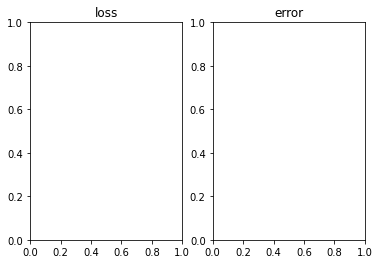

In [50]:
fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="error")
#ax1.set_color_cycle([cm(1.*i/len(tasks)) for i in range(len(tasks))])
colors = plt.cm.Spectral(np.linspace(0,1,len(tasks)))
ax1.set_prop_cycle('color', colors)

In [51]:
def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax0.plot(x_epoch, y_loss['val'], 'ro-', label='val')
    for i in range(len(tasks)):
        ax1.plot(x_epoch, y_acc[tasks[i]], label= tasks[i])
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    fig.savefig(os.path.join('./lossGraphs', 'train.jpg'))

In [52]:
for epoch in range(NUM_EPOCHS):
    print("epoch [%d/%d]"%(epoch+1, NUM_EPOCHS))
    train_loss = 0
    train_bar = FloatProgress(min=0, max=TRAIN_SIZE)
    display(train_bar)
    for batch in range(0, TRAIN_SIZE, BATCH_SIZE):
        batch_loss = 0
        optimizer.zero_grad()
        for sample in range(BATCH_SIZE):
            #print(index)
            index = sample + batch
            #print(index)
            smile = X_train.iloc[index]['smiles']
            #print('beep1')
            y_hat = model(smile)
            #print('beep1')
            y_tru = torch.Tensor(y_train.iloc[index].values.reshape(1, V))
            #print("y_train[index]: ",y_train.iloc[index])
            y_hat1=y_hat;
            #print("y_hat: ",y_hat1.reshape(V, 1))
#             df.loc[len(df)] = y_hat
            if(epoch==2):
                y_hat1=y_hat.detach().numpy()
                df1=pd.DataFrame(y_hat1,columns=['col1','col2','col3','col4','col5','col6','col7','col8','col9','col10','col11'])
                #dfn=dfn.append(df1)
                dfn = pd.concat([dfn, df1])
            batch_loss += batch_mse_loss(y_hat, y_tru)
            train_bar.value += 1
        train_loss += (batch_loss * scale_batch_to_train).detach()
        batch_loss.backward()
        optimizer.step()
    valid_loss = 0
    accu_check = 0
    valid_bar = FloatProgress(min=0, max=VALID_SIZE)
    display(valid_bar)
    for sample in range(VALID_SIZE):
        index = sample
        smile = X_val.iloc[index]['smiles']
        y_hat = model(smile)
        y_tru = torch.Tensor(y_val.iloc[index].values.reshape(1, V))
        valid_loss += valid_mse_loss(y_hat, y_tru)
        accu_check += np.abs(scaler.inverse_transform(y_hat.detach()) - \
                             scaler.inverse_transform(y_tru.detach())) / VALID_SIZE
        valid_bar.value += 1
    print('train_loss [%4.2f]'%(train_loss.item()))
    print('valid_loss [%4.2f]'%(valid_loss.item()))
    print('train_loss [%4.2f]' % (train_loss.item()))
    print('valid_loss [%4.2f]' % (valid_loss.item()))
    y_loss['train'].append(train_loss.item())
    y_loss['val'].append(valid_loss.item())
    for i in range(len(tasks)):
        y_acc[tasks[i]].append(accu_check[0][i])
    draw_curve(epoch)
    wandb.log({"loss": train_loss, "validation loss": valid_loss, tasks[0]: accu_check[0][0], tasks[1]: accu_check[0][1],
               tasks[2]: accu_check[0][2], tasks[3]: accu_check[0][3], tasks[4]: accu_check[0][4],
               tasks[5]: accu_check[0][5], tasks[6]: accu_check[0][6], tasks[7]: accu_check[0][7],
               tasks[8]: accu_check[0][8], tasks[9]: accu_check[0][9], tasks[10]: accu_check[0][10]})
    wandb.watch(model)
    print(accu_check)    

epoch [1/20]


FloatProgress(value=0.0, max=100000.0)

FloatProgress(value=0.0, max=30000.0)

train_loss [0.37]
valid_loss [0.22]
train_loss [0.37]
valid_loss [0.22]
[[9.31793337e-01 2.53851739e+00 1.02589023e-02 1.44715841e-02
  1.54645669e-02 7.28800807e-03 9.62026610e+00 8.84164091e+00
  8.67689514e+00 8.50876548e+00 1.19121798e+00]]
epoch [2/20]


FloatProgress(value=0.0, max=100000.0)

FloatProgress(value=0.0, max=30000.0)

train_loss [0.20]
valid_loss [0.19]
train_loss [0.20]
valid_loss [0.19]
[[8.46492592e-01 2.09265423e+00 9.32947369e-03 1.32448219e-02
  1.46430441e-02 6.44262843e-03 6.83855293e+00 6.82838644e+00
  6.87388365e+00 7.10086304e+00 1.04084425e+00]]
epoch [3/20]


FloatProgress(value=0.0, max=100000.0)

FloatProgress(value=0.0, max=30000.0)

train_loss [0.18]
valid_loss [0.18]
train_loss [0.18]
valid_loss [0.18]
[[8.15501108e-01 2.07861544e+00 9.05401325e-03 1.27463495e-02
  1.42856201e-02 6.22333253e-03 6.26129343e+00 6.25356295e+00
  6.27796812e+00 6.67796922e+00 9.77938292e-01]]
epoch [4/20]


FloatProgress(value=0.0, max=100000.0)

FloatProgress(value=0.0, max=30000.0)

train_loss [0.17]
valid_loss [0.17]
train_loss [0.17]
valid_loss [0.17]
[[7.96911345e-01 2.01137447e+00 8.87856740e-03 1.23122120e-02
  1.39020829e-02 6.06260423e-03 5.88445150e+00 5.89117884e+00
  5.90906194e+00 6.18952738e+00 9.37949371e-01]]
epoch [5/20]


FloatProgress(value=0.0, max=100000.0)

FloatProgress(value=0.0, max=30000.0)

train_loss [0.17]
valid_loss [0.17]
train_loss [0.17]
valid_loss [0.17]
[[7.85146575e-01 1.95690857e+00 8.73446029e-03 1.18701737e-02
  1.35411991e-02 5.87275515e-03 5.61196383e+00 5.70335336e+00
  5.68970325e+00 5.95076246e+00 9.25019499e-01]]
epoch [6/20]


FloatProgress(value=0.0, max=100000.0)

KeyboardInterrupt: 

In [ ]:
# DONT GO AHEAD#
dfn

In [ ]:
for batch in range(0, TRAIN_SIZE, BATCH_SIZE):
        batch_loss = 0
        optimizer.zero_grad()
        for sample in range(BATCH_SIZE):
            #print(index)
            index = sample + batch
            print(index)
            smile = X_train.iloc[index]['smiles']
            print(smile)

In [ ]:
# y_train

In [ ]:
# smile = "C1(C)C(Br)C1"

In [ ]:
# g = OrderedDict({})
# h = OrderedDict({})
# #h[-1] = 0
# molecule = Chem.MolFromSmiles(smile)
# #mol_matrix = [['0','1','0','0','0'],['1','0','2','0','1'],['0','2','0','1','1'],['0','0','1','0','0'],['0','1','1','0','0']]
# for i in range(molecule.GetNumAtoms()):
#     atom_i = molecule.GetAtomWithIdx(i)
#     atom_i_featurized = dc.feat.graph_features.atom_features(atom_i)
#     atom_i_tensorized = torch.FloatTensor(atom_i_featurized).view(1, D)
#     h[i] = atom_i_tensorized
#     #h[-1] += h[i]
#     master_edge = master_edge_learner(h[i])
#     g.setdefault(i, [])
#     #.append((master_edge, -1))
#     #g.setdefault(-1, [])
#     #.append((master_edge, i))
#     for j in range(molecule.GetNumAtoms()):
#         bond_ij = molecule.GetBondBetweenAtoms(i, j)
#         if bond_ij: # bond_ij is None when there is no bond.
#             #atom_j = molecule.GetAtomWithIdx(j)
#             #atom_j_featurized = dc.feat.graph_features.atom_features(atom_j)
#             #atom_j_tensorized = torch.FloatTensor(atom_j_featurized).view(1, 75)
#             bond_ij_featurized = dc.feat.graph_features.bond_features(bond_ij).astype(int)
#             bond_ij_tensorized = torch.FloatTensor(bond_ij_featurized).view(1, E)
#             g.setdefault(i, []).append((bond_ij_tensorized, j))

In [ ]:
# print(g)
# print(h)

In [ ]:
# cycles = [[],[],[]]

In [ ]:
# def cycles_list(edges_1,mark,cycle_number):
#   for i in range(edges):
#     if(mark[i]!=0):
#       #print(mark[i],i)
#       cycles[mark[i]].append(i)
#   #for i in range(cycle_number+1):
#     #print(cycles[i])

In [ ]:
# dfs_cycle(0, -1 , color, mark, par, cyclenumber,g)

In [ ]:
# print(len(h))

In [ ]:
# cycles_list(edges,mark,max(mark))

In [ ]:
# num_of_atoms = 5
# for i in range(len(cycles)):
#   if(len(cycles[i])>=3):
#     h[len(h)]=0
#     for j in range(len(cycles[i])):
#       print(len(h)-1)
#       h[len(h)-1]+=h[cycles[i][j]]
#       master_edge = master_edge_learner(h[cycles[i][j]])
#       g[cycles[i][j]].append((master_edge, -1))
#       g.setdefault(len(h)-1, []).append((master_edge, cycles[i][j]))
# print(len(h))
# #for x in range (num_of_atoms,len(h)):
#   #h[-1]+=h[x]
#   #master_edge = master_edge_learner(h[x])
#   #g[x].append((master_edge, -1))
#   #g.setdefault(-1, []).append((master_edge, h[x])

In [ ]:
# print(len(g))
# print(len(h))

In [ ]:
# h[len(h)]=0
# for x in range (num_of_atoms,len(h)-1):
#   print(len(h))
#   h[len(h)-1]+=h[x]
#   master_edge = master_edge_learner(h[x])
#   g[x].append((master_edge, -1))
#   g.setdefault(-1, []).append((master_edge, h[x]))

In [ ]:
# print(g)